In [38]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   main.ipynb
	modified:   main_distributed.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [17]:
import os
import time
import json
import numpy as np
from scipy.stats import kendalltau
from scipy.spatial.distance import cdist
from itertools import chain, product
from src.lexrank import degree_centrality_scores
from sklearn.decomposition import PCA
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_documents
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import src.sinkhorn_pointcloud as spc
from src.layers import SinkhornDistance
from geomloss import SamplesLoss
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

import ray

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

import ot

torch.manual_seed(42)
dtype = torch.float
device = torch.device('cuda:0')
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [2]:
DATASET_TRAIN = DATASETS[0]
DATASET_TEST = DATASETS[1]
TOPIC_ID_TRAIN = TOPICS[DATASET_TRAIN][0]
TOPIC_ID_TEST = TOPICS[DATASET_TEST][1]
DATA_DIR = f'/scratch/korunosk/data'
EMBEDDINGS_DIR = os.path.join(DATA_DIR, 'fasttext')

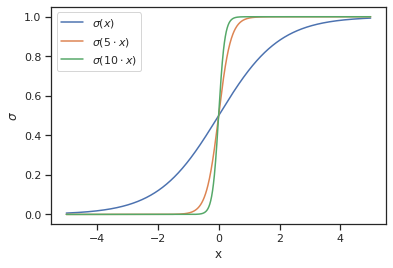

In [35]:
x=np.arange(-5,5,0.01)
y1=1/(1 + np.exp(-x))
y2=1/(1 + np.exp(-5*x))
y3=1/(1 + np.exp(-10*x))
plt.plot(x,y1,label='$\sigma(x)$')
plt.plot(x,y2,label='$\sigma(5 \cdot x)$')
plt.plot(x,y3,label='$\sigma(10 \cdot x)$')
plt.xlabel('x')
plt.ylabel('$\sigma$')
plt.legend()
plt.show()

Try out:
- Play with the parameters: D_out, blur in SampleLoss, learning rate
- Normalize embeddings
- Batching
- sigmoid(10 * x)

Validate using:
- correlation

In [3]:
def make_artificial_topic_data(dim: int=300, n: int=50, d_s: int=100, s_s: int=10) -> tuple:
    ''' Generates artificial data.
    
    :param dim: Embedding size
    :param n:   Number of summaries
    :param d_s: Number of embeddings per documents
    :param s_s: Number of embeddings per summary
    :return:    The data
    '''
    
    # tolist() just to be consistent
    document_embs = np.random.uniform(-1, 1, size=(d_s, dim)).tolist()
    summary_embs  = np.random.uniform(-1, 1, size=(s_s * n, dim)).tolist()
    rang          = np.arange(0, n)
    indices       = np.column_stack((s_s * rang, s_s * (rang+1))).tolist()
    pyr_scores    = np.random.uniform(size=n).tolist()
    
    return document_embs, summary_embs, indices, pyr_scores, None

In [4]:
def make_tuples_data_for_regression(dataset, topic_id: str) -> list:
    ''' Generates data for regression in the form:
    
    (topic_id: str, i: int), where:
    
    topic_id - the topic ID
    i        - index of the summary

    :param dataset:  The dataset to fetch data from
    :param topic_od: Topic ID
    :return:         The data
    '''
    topic = load_data(os.path.join(EMBEDDINGS_DIR, dataset), topic_id, encoded=True)
    _, _, _, pyr_scores, _ = extract(topic)
    
    data = []
    n = len(pyr_scores)
    for i in range(n):
        data.append((topic_id, i))
    
    return data

def make_tuples_data_for_classification(dataset, topic_id: str) -> list:
    ''' Generates data for classification in the form:
    
    (topic_id: str, i1: int, i2: int, y: int), where:
    
    topic_id - the topic ID
    i1       - index of the first summary
    i2       - index of the second summary
    y        - {0,1} indicator variable, whether pyramid[i1] > pyramid[i2]

    :param dataset:  The dataset to fetch data from
    :param topic_od: Topic ID
    :return:         The data
    '''
    topic = load_data(os.path.join(EMBEDDINGS_DIR, dataset), topic_id, encoded=True)
    _, _, _, pyr_scores, _ = extract(topic)
    
    data = []
    n = len(pyr_scores)
    for i1, i2 in product(range(n), range(n)):
        if i1 == i2:
            continue
        y = int(pyr_scores[i1] > pyr_scores[i2])
        data.append((topic_id, i1, i2, y))
    
    return data

In [5]:
class TACDataset(Dataset):
    def _load_topic(self, topic_id):
        if self.topic_id == topic_id:
            return
        
        self.topic_id = topic_id
        
        if self.encoded:
            topic = load_data(os.path.join(EMBEDDINGS_DIR, self.dataset), topic_id, encoded=True)
        else:
            topic = load_data(DATA_DIR, self.dataset, encoded=False)[self.topic_id]
            
        (self.documents,
         self.summaries,
         self.indices,
         self.pyr_scores,
         self.summary_ids) = extract(topic)
        
        print(f'Loaded data from topic {topic_id}')

    def __init__(self, dataset, data, encoded):
        self.dataset = dataset
        self.data = data
        self.encoded = encoded
        self.topic_id = ''
        
        self._load_topic(self.data[0][0])        
        
    def __len__(self):
        return len(self.data)


class TACDatasetRegression(TACDataset):
    def __init__(self, dataset, data):
        super().__init__(dataset, data, encoded=True)
        
    def __getitem__(self, idx):
        self._load_topic(self.data[idx][0])
        
        i = self.indices[int(self.data[idx][1])]
        x = (self.documents,
             self.summaries[i[0]:i[1]])
        y = self.pyr_scores[int(self.data[idx][1])]
        
        return (x, y)


class TACDatasetClassification(TACDataset):
    def __init__(self, dataset, data):
        super().__init__(dataset, data, encoded=True)
        
    def __getitem__(self, idx):
        self._load_topic(self.data[idx][0])
        
        i1 = self.indices[int(self.data[idx][1])]
        i2 = self.indices[int(self.data[idx][2])]
        x = (self.documents,
             self.summaries[i1[0]:i1[1]],
             self.summaries[i2[0]:i2[1]])
        y = float(self.data[idx][3])
        
        return (x, y)


class TACDatasetClassificationScoring(TACDataset):
    def _load_topic(self, topic_id):
        super()._load_topic(topic_id)
        self.dct = Dictionary(preprocess_documents(self.documents + self.summaries))

    def __init__(self, dataset, data):
        super().__init__(dataset, data, encoded=False)
    
    def doc2idx(self, document):
        return list(map(self.dct.doc2idx, preprocess_documents(document)))
    
    def num_nnz(self):
        return self.dct.num_nnz
    
    def __getitem__(self, idx):
        self._load_topic(self.data[idx][0])
        
        i1 = self.indices[int(self.data[idx][1])]
        i2 = self.indices[int(self.data[idx][2])]
        x = (self.doc2idx(self.documents),
             self.doc2idx(self.summaries[i1[0]:i1[1]]),
             self.doc2idx(self.summaries[i2[0]:i2[1]]))
        y = float(self.data[idx][3])
        
        return (x, y)

In [6]:
class Normalize():
    def __call__(self, sample):
        x, y = sample
        return (tuple(normalize(x_i, axis=1) for x_i in x), y)


class ToTensor():
    def __call__(self, sample):
        x, y = sample
        return (tuple(torch.tensor(x_i) for x_i in x), torch.tensor(y))

### Make data

In [7]:
def stratified_sampling(data):
    train, test = train_test_split(data, test_size=0.3, random_state=42, stratify=data[:,0])
    # Sort the data by topic_id since we will load each topic separatelly
    train = train[train[:,0].argsort(kind='mergesort')]
    test = test[test[:,0].argsort(kind='mergesort')]
    return train, test

def leave_n_out(topics, data, n):
    train_topics = topics[:-n]
    test_topics = topics[-n:]
    train = data[np.isin(data[:,0], train_topics)]
    test = data[np.isin(data[:,0], test_topics)]
    return train, test

In [8]:
### Train
topic = load_data(DATA_DIR, DATASET_TRAIN, encoded=False)
data_train = extract(topic[TOPIC_ID_TRAIN])

topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_TRAIN), TOPIC_ID_TRAIN, encoded=True)
data_encoded_train = extract(topic)

### Test
topic = load_data(DATA_DIR, DATASET_TEST, encoded=False)
data_test = extract(topic[TOPIC_ID_TEST])

topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_TEST), TOPIC_ID_TEST, encoded=True)
data_encoded_test = extract(topic)

#### For all topics

In [9]:
# tuples_data = []
# for topic_id in TOPICS[DATASET_TRAIN]:
#     tuples_data.extend(make_tuples_data_for_classification(DATASET_TRAIN, topic_id))
# tuples_data = np.array(tuples_data)

# tuples_train, tuples_val = stratified_sampling(tuples_data)

# tuples_train.shape, tuples_val.shape

#### For single topic

In [10]:
tuples_data = make_tuples_data_for_regression(DATASET_TRAIN, TOPIC_ID_TRAIN)
tuples_data = np.array(tuples_data)

tuples_train_regression, tuples_val_regression = tuples_data, np.array([])

tuples_train_regression.shape, tuples_val_regression.shape

((62, 2), (0,))

In [11]:
tuples_data = make_tuples_data_for_classification(DATASET_TRAIN, TOPIC_ID_TRAIN)
tuples_data = np.array(tuples_data)

tuples_train_classification, tuples_val_classification = tuples_data, np.array([])

tuples_train_classification.shape, tuples_val_classification.shape

((3782, 4), (0,))

# Learning transformation

## Regression

In [12]:
# write as config {}
D_in = 300
D_out = 100
p = 2
blur = .05
scaling = .9
learning_rate = 1e-2
batch_size = 100


class SinkhornRegressionModel(nn.Module):
    def __init__(self, D_in, D_out):
        super(SinkhornRegressionModel, self).__init__()
        self.M = nn.Parameter(torch.randn(D_in, D_out))
        self.sinkhorn = SamplesLoss(loss='sinkhorn', p=p, blur=blur, scaling=scaling)

    def forward(self, d, s):
        dist = self.sinkhorn(torch.mm(d, self.M), torch.mm(s, self.M))
        return torch.exp(-dist)

Loaded data from topic D0841
0.0024
0.0380
0.0024
0.1722
0.0053
0.0149
0.0292
0.0096
0.0000
0.0006
0.1005
0.1005
0.2621
0.0292
0.1005
0.0149
0.0024
0.0213
0.0053
0.0718
0.0380
0.0213
0.1340
0.1340
0.0213
0.0149
0.1163
0.0024
0.0096
0.0096
0.1340
0.0213
0.0213
0.0718
0.0595
0.0484
0.0149
0.0380
0.0096
0.0213
0.0292
0.1005
0.2621
0.0149
0.0858
0.0858
0.0213
0.0024
0.0213
0.1722
0.0213
0.0380
0.0149
0.0024
0.0096
0.0053
0.1521
0.0718
0.1600
0.7517
0.1806
1.8171


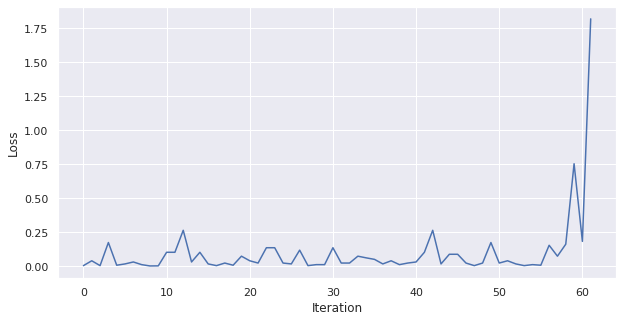

In [13]:
# maybe generalize the training procedure

transform = transforms.Compose([Normalize(), ToTensor()])
dataset = TACDatasetRegression(DATASET_TRAIN, tuples_train_regression)
data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

sinkhornRegressionModel = SinkhornRegressionModel(D_in, D_out)

criterion = nn.MSELoss()
optimizer = optim.SGD(sinkhornRegressionModel.parameters(), lr=learning_rate)

loss = []

for batch in data_loader:
    for sample in batch:
        (d, s), y = transform(sample)

        L = criterion(sinkhornRegressionModel(d, s), y)

        loss.append(L.item())
        print(f'{loss[-1]:.4f}')

        optimizer.zero_grad()

        L.backward()

        optimizer.step()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

## Classification (Preference learning)

In [15]:
D_in = 300
D_out = 100
p = 2
blur = .05
scaling = .9
scaling_factor = 1
learning_rate = 1e-2
batch_size = 100


class SinkhornClassificationModel(nn.Module):
    def __init__(self, D_in, D_out):
        super(SinkhornClassificationModel, self).__init__()
        self.M = nn.Parameter(torch.randn(D_in, D_out))
        self.sinkhorn = SamplesLoss(loss='sinkhorn', p=p, blur=blur, scaling=scaling)
        self.sigm = nn.Sigmoid()

    def forward(self, d, s1, s2):
        dist1 = self.sinkhorn(torch.mm(d, self.M), torch.mm(s1, self.M))
        dist2 = self.sinkhorn(torch.mm(d, self.M), torch.mm(s2, self.M))
        return self.sigm(scaling_factor * (dist2 - dist1))

In [ ]:
transform = transforms.Compose([Normalize(), ToTensor()])
dataset = TACDatasetClassification(DATASET_TRAIN, tuples_train_classification)
data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

sinkhornClassificationModel = SinkhornClassificationModel(D_in, D_out)

criterion = nn.BCELoss()
optimizer = optim.SGD(sinkhornClassificationModel.parameters(), lr=learning_rate)

loss = []

for batch in data_loader:
    L = 0.0
    
    for sample in batch:
        (d, s1, s2), y = transform(sample)
                
        L += criterion(sinkhornClassificationModel(d, s1, s2), y)
        
        optimizer.step()
        
    loss.append(L.item())
    print(f'{loss[-1]:.4f}')
    
    optimizer.zero_grad()

    L.backward()
    
plot_loss(loss)

Loaded data from topic D0841
111.2374
34.1349
66.3440
42.3077
69.8126
46.9889
34.8645
29.1314
26.3789
58.5368
19.2335


In [17]:
def experiment_sinkhorn_distance(data, model, M=None):
    document_embs, summary_embs, indices, pyr_scores, _ = data
    document_embs = np.array(document_embs)
    if M is not None:
        document_embs = document_embs @ M
        summary_embs  = (np.array(summary_embs) @ M).tolist()
    metric = lambda i: model.sinkhorn(torch.tensor(document_embs), torch.tensor(np.array(summary_embs[i[0]:i[1]])))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

In [16]:
M = list(sinkhornRegressionModel.parameters())[0].data.cpu().numpy()

In [18]:
print(f'Correlation (before transformation): {experiment_sinkhorn_distance(data_encoded_train, sinkhornRegressionModel):.4f}')
print(f'Correlation (after transformation):  {experiment_sinkhorn_distance(data_encoded_train, sinkhornRegressionModel, M):.4f}')

Correlation (before transformation): 0.0011
Correlation (after transformation):  0.0457


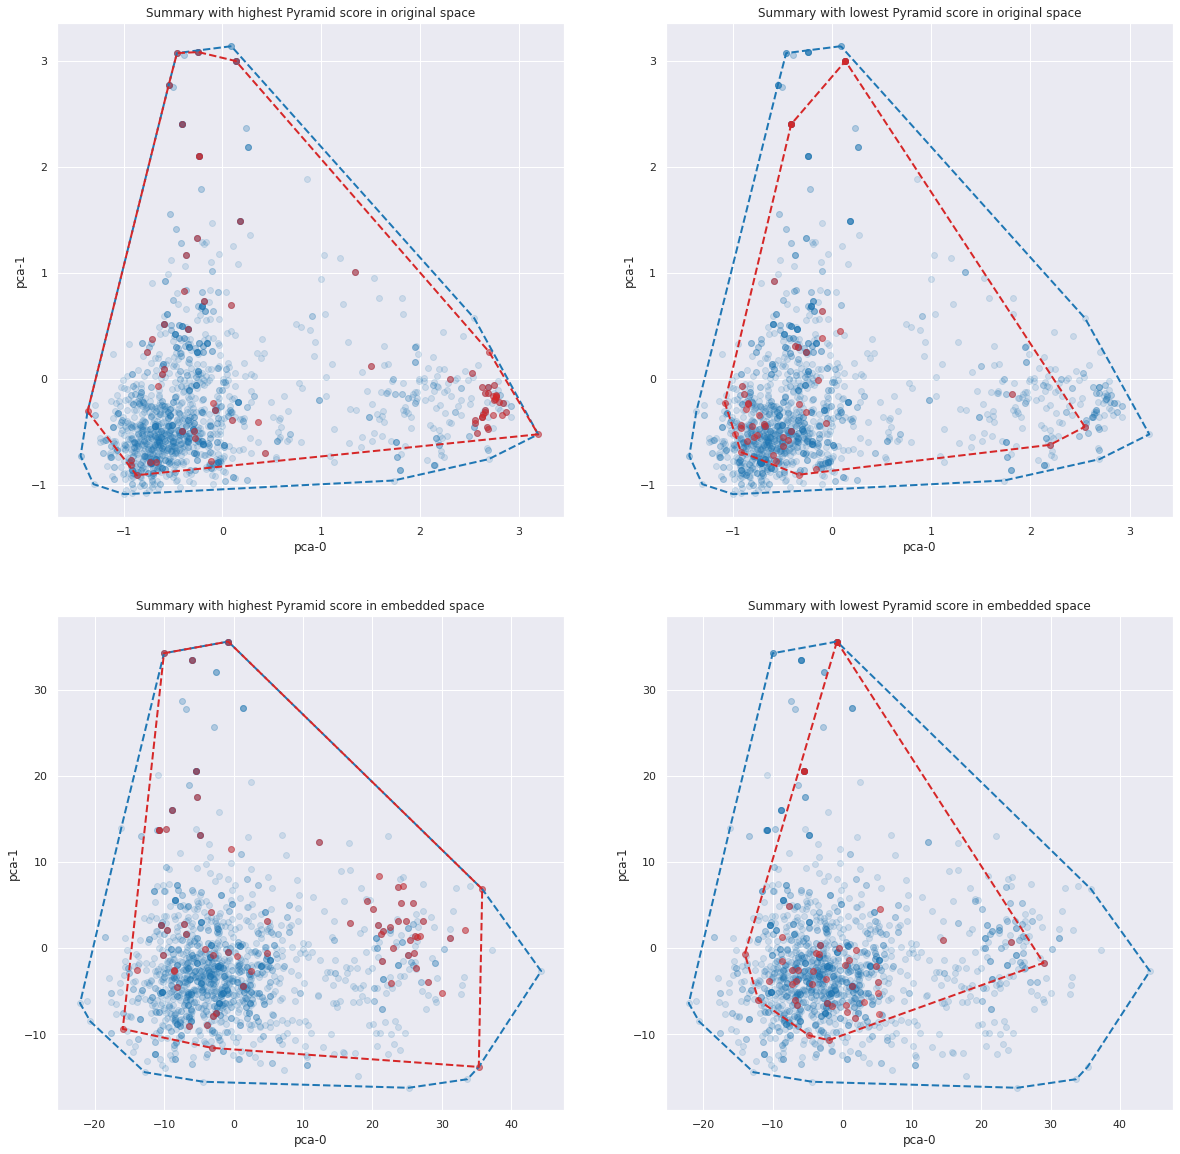

In [19]:
document_embs, summary_embs, indices, pyr_scores, _ = data_encoded_train

m = np.argsort(-np.array(pyr_scores))

b, w = 0, -1

fig = plt.figure(figsize=(20,20))

document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

ax1 = fig.add_subplot(2,2,1)
plot_hull(ax1, 'Summary with highest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
ax2 = fig.add_subplot(2,2,2)
plot_hull(ax2, 'Summary with lowest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

document_pts, summary_pts = project_pca(np.concatenate((document_embs @ M, summary_embs @ M)), len(document_embs))

ax3 = fig.add_subplot(2,2,3)
plot_hull(ax3, 'Summary with highest Pyramid score in embedded space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
ax4 = fig.add_subplot(2,2,4)
plot_hull(ax4, 'Summary with lowest Pyramid score in embedded space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

plt.show()

In [20]:
print(f'Correlation (before transformation): {experiment_sinkhorn_distance(data_encoded_test, sinkhornRegressionModel):.4f}')
print(f'Correlation (after transformation):  {experiment_sinkhorn_distance(data_encoded_test, sinkhornRegressionModel, M):.4f}')

Correlation (before transformation): 0.0272
Correlation (after transformation):  0.0573


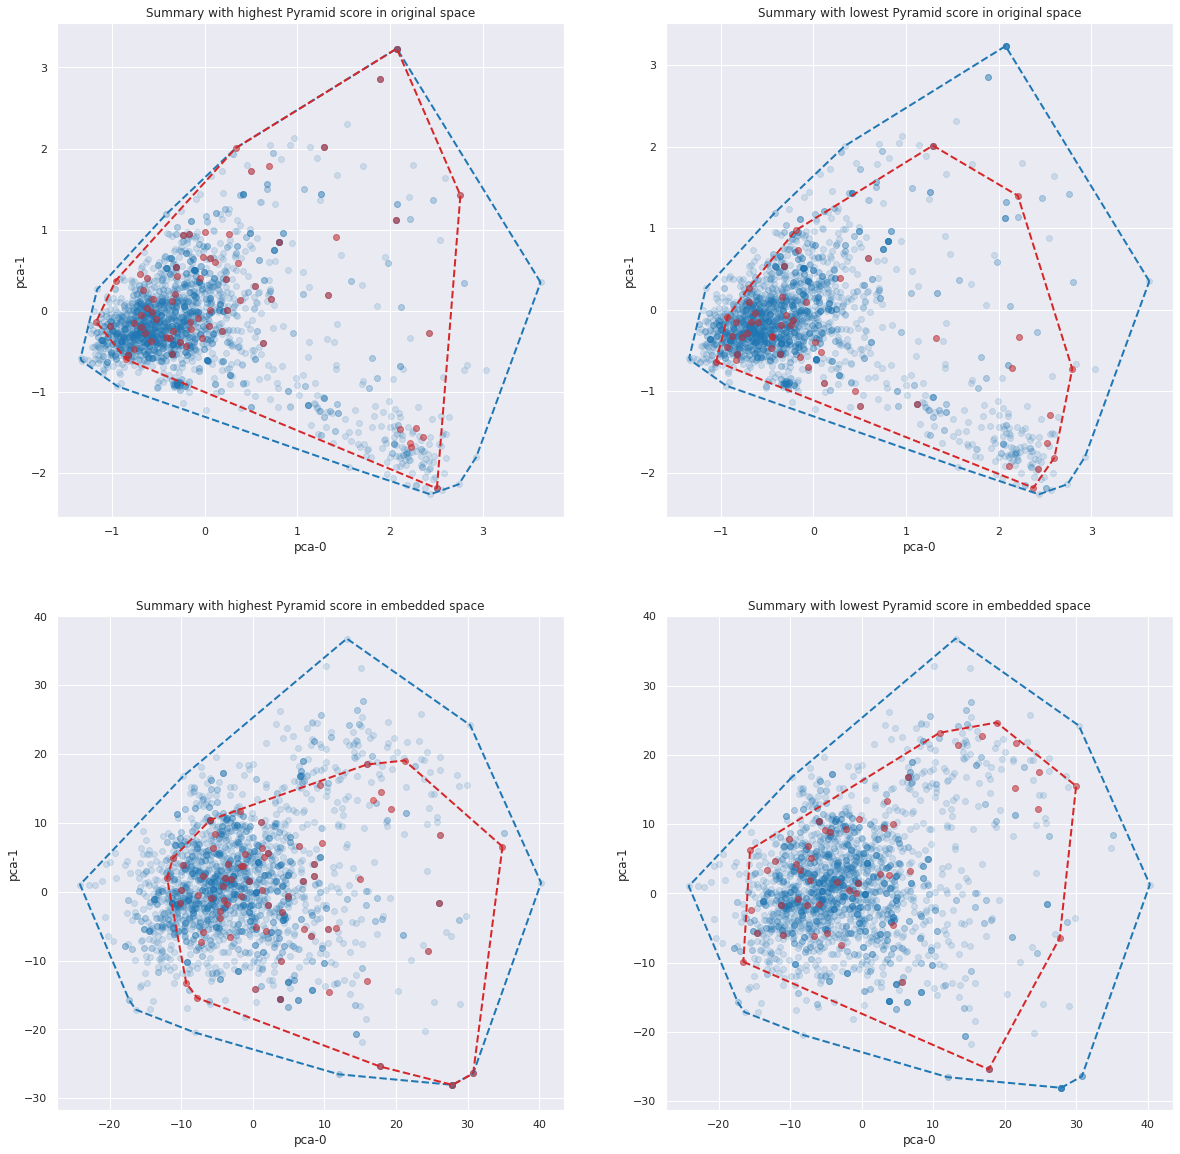

In [21]:
document_embs, summary_embs, indices, pyr_scores, _ = data_encoded_test

m = np.argsort(-np.array(pyr_scores))

b, w = 0, -1

fig = plt.figure(figsize=(20,20))

document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

ax1 = fig.add_subplot(2,2,1)
plot_hull(ax1, 'Summary with highest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
ax2 = fig.add_subplot(2,2,2)
plot_hull(ax2, 'Summary with lowest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

document_pts, summary_pts = project_pca(np.concatenate((document_embs @ M, summary_embs @ M)), len(document_embs))

ax3 = fig.add_subplot(2,2,3)
plot_hull(ax3, 'Summary with highest Pyramid score in embedded space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
ax4 = fig.add_subplot(2,2,4)
plot_hull(ax4, 'Summary with lowest Pyramid score in embedded space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

plt.show()

# Scoring

## Learning Embeddings

In [16]:
emb_dim = 300
D_in = 2 * emb_dim
H = 2 * D_in
scaling_factor = 1
learning_rate = 1e-4
batch_size = 100

class Model(nn.Module):
    def __init__(self, num_emb, emb_dim, D_in, H):
        super(Model, self).__init__()
        self.emb = nn.Embedding(num_emb, emb_dim)
        self.layer1 = nn.Linear(D_in, H)
        self.layer2 = nn.Linear(H, 1)
        self.sigm = nn.Sigmoid()
    
    def score(self, d, s):
        return sum([self.predict(d, si) for si in s]).squeeze()
    
    def embed(self, d):
        from_table = lambda w: self.emb(torch.tensor([w])).mean(axis=0)
        return torch.cat(list(map(from_table, d)), axis=0)
        
    def predict(self, d, s):
        ds = torch.cat((d, s), axis=0)
        z = self.layer1(ds)
        a = F.relu(z)
        return self.layer2(a)
    
    def forward(self, d, s1, s2):
        d  = self.embed(d).mean(axis=0)
        s1 = self.embed(s1)
        s2 = self.embed(s2)
        return self.sigm(scaling_factor * (self.score(d, s1) - self.score(d, s2)))

Loaded data from topic D0841
0.61578019
0.69314718
2.09552491
0.13730599
0.18470114
0.11857811
0.00038181
5.06209823
4.93382489
0.00426319
0.00009561
0.00084551
0.00148695
0.00083803
0.00564160
0.05274291
0.00721096
0.72875138
0.02445572
0.00002545
0.00561432
0.00334688
0.00155011
0.00120528
0.00100913
0.00116834
0.00158223
0.00792425
0.00197759
0.00045198
0.00175453
0.00472034
0.00262332
0.00000111
0.00012081
0.00006062
0.00142359
0.22736851
0.00240037
0.00057688
0.00205134
0.00037859
0.00068080
0.00004249
0.01178818
0.00378188
0.00049423
0.22801572
0.00022680
0.00002191
0.00001772
0.00053340
0.00034290
0.00024562
0.00448806
0.00025770
0.00471994
0.00192908
0.00000667
0.00039990
0.00000005
0.00000035
0.00000034
3.85383918
0.00614803
0.00067385
0.00831404
0.08023988
0.00003906
0.00002309
0.83509453
0.14556620
0.10423512
0.74476554
0.00673778
0.75363829
0.34584122
0.92833925
0.38745676
0.94606338
0.47969096
0.26354249
1.08167364
0.02068513
0.35200444
0.04330469
0.06829075
1.59047266
0.0

0.00003290
0.00151604
0.00000001
0.00422577
0.00000012
0.00000000
0.00000000
0.00000000
0.00000015
0.00000013
0.00000003
0.00000425
0.00165269
0.00000124
0.00000002
0.00025003
0.00000000
0.00000000
0.00000000
0.00003919
0.00000000
0.00000000
0.00000004
0.00000015
0.00003838
0.00000061
0.00000052
0.00000000
0.00000031
0.00000159
0.00202891
0.69314718
0.00001299
0.00001357
0.00000096
0.00000000
0.00000000
0.00000005
0.00762900
0.00002471
0.00016750
0.00000054
0.00000000
0.00000162
0.00000000
0.01472340
0.00092983
2.96040433
0.61897104
0.40391479
0.00000135
0.02958169
0.13773702
0.01862939
0.00000154
0.19580570
1.81504411
0.05586743
1.54217764
0.00000000
0.00000004
0.00323110
0.00009862
0.00000000
0.00189501
0.74361986
0.00000646
0.00028916
0.00001549
1.34636485
3.57019969
1.27774822
0.33676612
0.00060762
3.11435405
0.58474642
0.00261286
0.00032643
0.03368073
0.00070385
0.00082382
0.01133345
0.00043499
4.73768273
0.21851740
0.00744606
2.18056102
0.15627205
0.00000029
0.89465981
0.11140022

0.02408554
0.01158494
0.00000002
0.01396252
0.00587405
0.00001479
1.18239497
0.29261712
0.15443334
0.00276599
0.00465081
0.62234582
0.00103101
0.00041774
0.22153912
1.22560349
0.00386692
0.00000000
0.99446543
0.00235848
0.00032586
0.00167763
0.00015647
0.14428090
0.00000236
0.04500305
0.00051063
0.67429068
0.00002429
3.41672874
0.20145599
0.00000017
0.00024531
0.00000009
0.00000007
0.00000058
0.00000000
1.36463397
0.00000343
0.94075091
0.00000000
0.64098031
0.01142934
0.00008904
0.27870692
0.00000261
0.00000642
0.00000131
0.00001042
0.00000001
0.16292844
0.00548166
1.56311089
0.00001221
0.01064062
0.00086566
0.00112473
0.00030985
0.01774036
0.00002745
0.00000442
0.16561579
0.01095932
0.00000014
0.03796723
0.08198729
0.00000034
0.03655516
0.02159857
0.00413876
0.00002043
0.00008711
0.99389083
0.00078946
0.00096684
0.02695206
0.01513401
0.00084099
0.00000000
0.44863458
0.00042298
0.00002636
0.00058942
0.00006602
0.35926850
0.00000014
0.00017579
0.00006300
2.38111347
0.00000499
6.98577557

0.80332107
0.01783718
0.00000716
0.00000000
0.01859446
0.00002628
0.00000523
0.03246760
0.00008984
0.00168925
0.00000001
0.00211287
0.00291987
0.00815381
0.00005072
3.63079948
0.01182757
0.00000001
0.00000279
0.00000000
0.00000000
0.00000000
0.00000000
0.00021364
0.01213252
0.00022835
0.00001454
0.00005431
0.71336673
0.41183618
0.00033848
0.00000023
0.00000003
0.00000027
0.00013230
0.00000001
0.12383118
0.00045928
0.11864055
0.00001816
0.38208045
0.00012619
0.00252663
0.20596997
0.61862134
0.00164879
0.00000057
0.02904207
0.00096497
0.00151101
0.00000001
0.00001328
0.00000674
0.00006562
0.00867407
0.00127520
0.03242894
0.45728107
0.01881977
0.00051030
0.00001671
0.18616372
0.73523840
0.00606447
0.00000060
0.01258699
0.14795437
0.06311421
0.00762693
0.00000001
0.04670044
0.00005919
0.01845839
2.52034452
0.00120213
0.00000000
0.00366990
0.00000087
0.00003337
0.00830288
0.00000289
0.00000337
0.00000092
0.00000000
0.14029238
0.00000020
0.12289987
0.00000002
0.03862299
0.13663492
0.00048675

0.00043474
2.34403169
0.00236779
0.00000000
0.00007452
0.00000002
0.00000000
0.00000000
0.00000000
0.00000000
0.00000468
0.00000000
3.86608562
0.00000000
0.00000003
0.00001901
0.00000000
0.00000000
0.00000000
7.52741584
1.51031653
0.00906269
0.00000515
0.46110001
0.00000002
0.00000000
0.00000075
0.00000000
0.00000374
0.00004929
0.00000573
0.00104583
6.45706293
0.00000022
0.00000000
0.00052772
0.00000000
0.00000000
0.00000000
0.04698294
0.00000049
0.00000008
0.00000374
0.00000778
0.00067426
0.00000000
0.00001046
0.00000000
0.00000033
0.00000018
0.00007394
0.20381245
0.00000000
0.00003043
0.00018734
0.00000006
0.00000000
0.00000001
0.00000002
0.00000022
0.00000000
0.00000000
0.00000000
0.00000000
0.17431263
0.00000541
0.26726030
0.03330571
0.52870740
0.00000001
0.00007826
0.00565324
0.00006668
0.00000009
0.00001565
0.32594365
0.01155962
0.00013763
0.00000004
0.00000002
0.00000015
0.00001765
0.00000000
2.04060664
0.00010124
0.01875451
0.00003310
0.88398279
0.00005099
0.09341902
0.00252280

0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000052
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000053
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000231
0.00000002


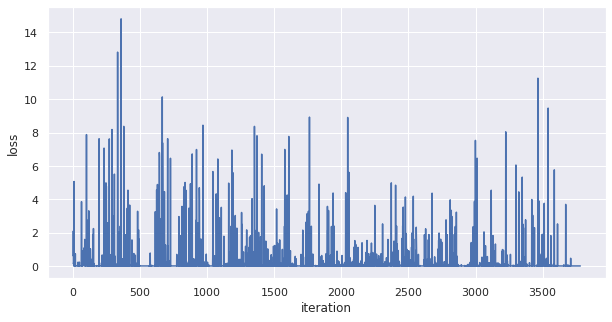

In [17]:
dataset = TACDatasetClassificationScoring(DATASET_TRAIN, tuples_train)
data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

model = Model(dataset.num_nnz(), emb_dim, D_in, H).cuda()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss = []

for batch in data_loader:
    for sample in batch:
        (d, s1, s2), y = sample
        
        L = criterion(model(d, s1, s2), torch.tensor(y))

        optimizer.step()

        loss.append(L.item())
        print(f'{loss[-1]:.8f}')

        optimizer.zero_grad()

        L.backward()

plot_loss(loss)

## Existing Embeddings

In [18]:
emb_dim = 300
D_in = 2 * emb_dim
H = 2 * D_in
scaling_factor = 10
learning_rate = 1e-4
batch_size = 100

class Model(nn.Module):
    def __init__(self, D_in, H):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(D_in, H)
        self.layer2 = nn.Linear(H, 1)
        self.sigm = nn.Sigmoid()
    
    def score(self, d, s):
        return sum([self.predict(d, si) for si in s]).squeeze()
    
    def predict(self, d, s):
        ds = torch.cat((d, s), axis=0)
        z = self.layer1(ds)
        a = F.relu(z)
        return self.layer2(a)
    
    def forward(self, d, s1, s2):
        d = d.mean(axis=0)
        return self.sigm(scaling_factor * (self.score(d, s1) - self.score(d, s2)))

Loaded data from topic D0841
3.101816
12.568556
21.487256
15.848544
17.689562
12.732083
16.938302
10.882999
8.318021
8.989776
9.505076
5.642935
7.899313
4.235232
5.198268
2.907095
3.904638
2.978983
1.374038
1.820731
1.642216
1.732721
0.588109
1.216126
0.949759
0.404980
0.792380
0.765881
0.464910
1.142958
1.056345
3.309231
1.556500
2.088502
0.431186
1.160374
0.854753
1.816480


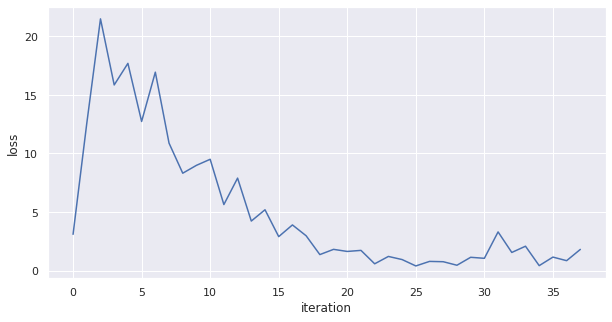

In [19]:
transform = transforms.Compose([ToTensor()])
dataset = TACDatasetClassification(DATASET_TRAIN, tuples_train)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

model = Model(D_in, H).cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss = []

for batch in data_loader:
    L = 0.0

    for sample in batch:
        (d, s1, s2), y = transform(sample)
        
        L += criterion(model(d, s1, s2), y).div(batch_size)

        optimizer.step()

    loss.append(L.item())
    print(f'{loss[-1]:4f}')

    optimizer.zero_grad()

    L.backward()

plot_loss(loss)

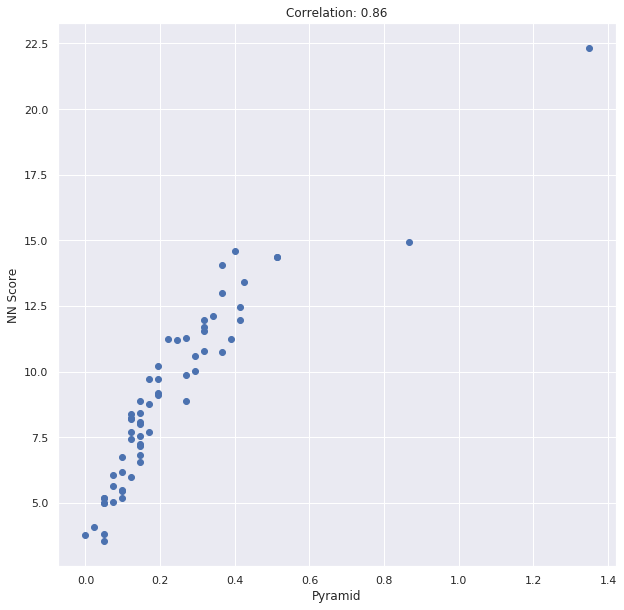

In [20]:
document_embs, summary_embs, indices, pyr_scores, _ = data_encoded_train
m = np.argsort(-np.array(pyr_scores))

x, y = np.array(pyr_scores)[m], []

d = torch.tensor(document_embs).mean(axis=0)
for i in np.array(indices)[m]:
    s = torch.tensor(summary_embs[i[0]:i[1]])
    y.append(model.score(d, s).cpu().data.numpy())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(x, y)
ax.set_title(f'Correlation: {kendalltau(x, y)[0]:.2f}')
ax.set_xlabel('Pyramid')
ax.set_ylabel('NN Score')
plt.show()

## Distributed computation of scores

In [18]:
ray.init(num_cpus=20)

2020-04-06 16:16:17,299	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-06 16:16:17,302	INFO resource_spec.py:212 -- Starting Ray with 189.79 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-06 16:16:19,876	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.90.38.13',
 'redis_address': '10.90.38.13:21859',
 'object_store_address': '/tmp/ray/session_2020-04-06_16-16-17_298569_49035/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-06_16-16-17_298569_49035/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-04-06_16-16-17_298569_49035'}

In [19]:
@ray.remote
def load_and_extract(data_dir, topic_id):
    topic = load_data(data_dir, topic_id, encoded=True)
    return extract(topic)

In [20]:
def execute_experiment(data_dir, tac, experiment):
    data   = [ load_and_extract.remote(data_dir, topic_id) for topic_id in tac ]
    scores = [ experiment.remote(d) for d in data ]

    return np.array(ray.get(scores))

In [21]:
@ray.remote
def experiment_average_pairwise_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: average_pairwise_distance(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_semantic_volume(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    metric = lambda i: semantic_volume(np.array(summary_pts[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_semantic_spread(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: semantic_spread(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_word_mover_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_hist = []
    # document_hist = np.empty(document_embs.shape[0])
    # document_hist.fill(1 / document_embs.shape[0])
    metric = lambda i: word_mover_distance(document_embs, np.array(summary_embs[i[0]:i[1]]), document_hist)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

@ray.remote
def experiment_lex_rank(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    metric = lambda i: lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

In [22]:
scores = [
    {
        'label': 'Average pairwise distance',
        'experiment': experiment_average_pairwise_distance 
    },
    {
        'label': 'Semantic volume',
        'experiment': experiment_semantic_volume 
    },
    {
        'label': 'Semantic spread',
        'experiment': experiment_semantic_spread 
    },
    {
        'label': 'Word Mover distance',
        'experiment': experiment_word_mover_distance 
    }
]

ptr = ''
print(f'=== Experiments {DATASET} ===\n')
for i,s in enumerate(scores):
    print('Executing "{}"'.format(s['label']))
    start = time.time()
    scores[i]['values'] = execute_experiment(os.path.join(EMBEDDINGS_DIR, DATASET), TOPICS[DATASET], s['experiment'])
    print('*** Elapsed: {:}\n'.format(format_time(time.time() - start)))
    ptr += '{:30} {:.4}\n'.format(s['label'], np.mean(scores[i]['values']))
    del s['experiment']
print('\n=== Results ===\n')
print(ptr)

=== Experiments TAC2008 ===

Executing "Average pairwise distance"
*** Elapsed: 0:00:03

Executing "Semantic volume"
*** Elapsed: 0:00:04

Executing "Semantic spread"
*** Elapsed: 0:00:02

Executing "Word Mover distance"
*** Elapsed: 0:00:11


=== Results ===

Average pairwise distance      0.1218
Semantic volume                0.1753
Semantic spread                0.04436
Word Mover distance            -0.1807



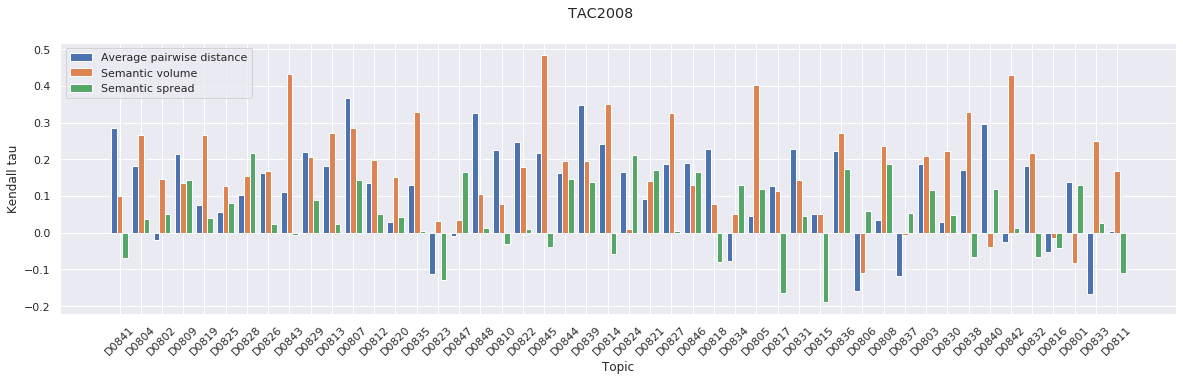

In [23]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(DATASET)
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores[:-1])
plt.show()

In [25]:
### Load
topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET), TOPIC_ID, encoded=True)

### Extract
document_embs, summary_embs, indices, pyr_scores, _ = extract(topic)

### Get indices of sorted pyramid scores
m = np.argsort(-np.array(pyr_scores))

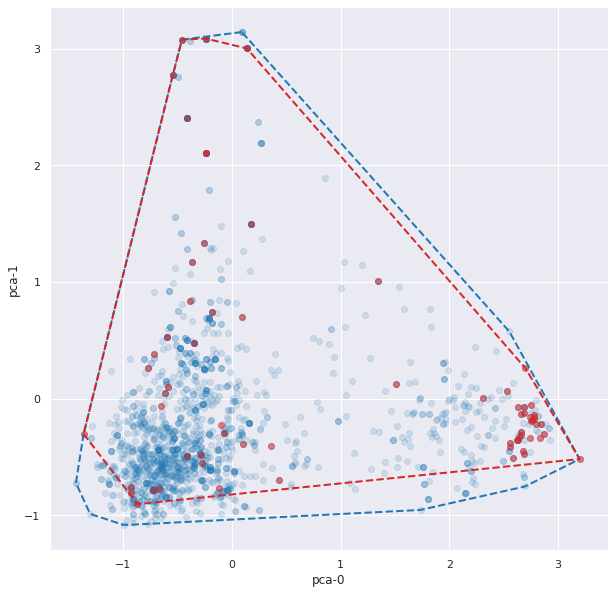

In [26]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
plot_hull(ax1, '', 'pca', document_pts, summary_pts[indices[m[0]][0]:indices[m[0]][1]])
plt.show()

In [27]:
ray.shutdown()

## Export embeddings

In [4]:
from config import *
from helpers import *

In [5]:
DATA_DIR = 'data'
EMBEDDINGS_DIR = os.path.join(DATA_DIR, 'fasttext')

In [6]:
from gensim.parsing.preprocessing import *
filters = [
    lambda s: s.lower(),
    strip_punctuation,
    strip_multiple_whitespaces,
    remove_stopwords,
]

In [7]:
vocab, embs = load_embeddings(os.path.join(EMBEDDINGS_DIR, 'crawl-300d-2M'))

In [18]:
def encode_words(documents):
    def encode(sentence):
        words = preprocess_string(sentence, filters)
        return [ list(embs[vocab[w]]) for w in words if w in vocab ]
    document_embs = []
    for document in documents:
        sentence_embs = []
        for sentence in document:
            sentence_embs.extend(encode(sentence))
        document_embs.append(sentence_embs)
    return document_embs

In [19]:
for dataset in DATASETS:
    print(dataset)
    data = load_data(DATA_DIR, dataset, encoded=False)
    for topic_id, topic in data.items():
        print('   {}'.format(topic_id))
        store_data(os.path.join(EMBEDDINGS_DIR, dataset), topic_id, make_topic(topic, encode_words))

TAC2008
   D0841
   D0804
   D0802
   D0809
   D0819
   D0825
   D0828
   D0826
   D0843
   D0829
   D0813
   D0807
   D0812
   D0820
   D0835
   D0823
   D0847
   D0848
   D0810
   D0822
   D0845
   D0844
   D0839
   D0814
   D0824
   D0821
   D0827
   D0846
   D0818
   D0834
   D0805
   D0817
   D0831
   D0815
   D0836
   D0806
   D0808
   D0837
   D0803
   D0830
   D0838
   D0840
   D0842
   D0832
   D0816
   D0801
   D0833
   D0811
TAC2009
   D0919
   D0904
   D0934
   D0928
   D0944
   D0917
   D0926
   D0921
   D0930
   D0907
   D0929
   D0913
   D0920
   D0909
   D0922
   D0935
   D0912
   D0903
   D0927
   D0940
   D0902
   D0925
   D0910
   D0931
   D0943
   D0939
   D0937
   D0933
   D0915
   D0941
   D0911
   D0924
   D0908
   D0932
   D0914
   D0916
   D0905
   D0923
   D0936
   D0938
   D0942
   D0918
   D0901
   D0906
